# Data Programming

## Report contents
- Inroduction and context
- Brief description of data
- High level description of data
    - Where it has come from 
    - Why is this data relevant
- Summary of key findings and insights
- Some discussion and critical analysis
- Conclusions and further work
- Rreferences


## Introduction and context
This project report is an exploratory data analysis of the academic journal Frontiers. According to the Frontiers website (https://www.frontiersin.org) homepage, it is the 3rd most cited and the 6th largest publisher with 1.9 billion article views and downloads. Presumably this is ranked against other journals worldwide however no such specific claims are made on this particular webpage.

Frontiers is open access and has little to no restrictions with regards to the use of its published content. It also has a fairly uniform and clearly laid out website design which makes it an ideal candidate for web scraping and data collection.

Although Frontiers is the name of the journal, it is really a collection journals all prefixed with the title "Frontiers in" and the name of the field. For example, Frontiers in Aerospace Engineering. Therefore in this report Frontiers will refer to the collection of journals and organisation as a whole while the use of the word journal will refer to the specific journal or journals in question. 

There is a well known replication crisis in the psychology with meta analysis of the literature showing this. It therefore seems like a good idea to begin to perform such meta analysis on the literature of other subjects with the view of identifying and flagging likley issues in other fields.   


## Data Aquisition
First of all we will take a look at the jouranl metadata from the list of journals available at https://www.frontiersin.org/journals.

The available data we will collect is the following.
- journal name
- sections
- articles
- article views
- IF (impact factor)
- citescore

In [50]:
from bs4 import BeautifulSoup
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from webdriver_manager.chrome import ChromeDriverManager
import time
import re

This webpage has a dynamically loading scroll feature and so the first thing we need to do is scroll to the bottom of the page
so all of the data can be scraped. This task can be automated using selenium. A sleep command at the end makes sure all the content has time to load and the fully loaded webpage is then captured in the soup variable using BeautifulSoup.

In [2]:
driver = webdriver.Chrome(service=Service(ChromeDriverManager().install()))
driver.get("https://www.frontiersin.org/journals")
driver.execute_script("window.scrollBy(0,document.body.scrollHeight)")
time.sleep(5)

soup = BeautifulSoup(driver.page_source, 'html.parser')

Next we want to retrieve each journal and its metadata information from the page. This information is contained in the "JournalCard__info" div's of the webpage.

In [21]:
def get_journals(soup):
    journal_info = soup.find_all('div', class_='JournalCard__info')
    journals = []
    for journal in journal_info:
        journals.append(journal)
    return journals

Now we can extract the information we need from each each journal card. The data will be formatted into a dictionary of dictionaries with the journal title as the key and the journal metrics being the values. These values are another dictionary where the metric title such as "article views" is the key and the corresponding number is the value.

example {'Frontiers in Aerospace Engineering New': {'sections': 5.0, 'articles': 10.0}

This data structure was chosen because it is very easy to convert it to a pandas dataframe.

The metric_to_dict function constructs the metric dictionary using the split_metric function to first convert all the string values that are numbers to floats and make sure the correct metric name is assigned to the correct value. Because the numbers are strings i used regex to identify any floats and also removed the commas used in numbers like '37,456,234'. Trailing spaces in the journal names were also removed.

Additionally there is a description of the journal and information reguarding the chief editor and the institution they are associated with. For simplicity I have not included these yet, and chosen to deal with the numerical data first, however they may contain some interesting insights and can always be added at a later date as they were captured in the soup object.

In [22]:
def split_metric(metric, keys, values):
    is_float = re.compile("^[0-9]*.[0-9]*$")
    if metric.text:
        for data in metric.text.split():
            item = data.replace(",", "")
            if item != "views":
                if item.isdigit() or is_float.match(item):
                    values.append(float(item))
                else:
                    keys.append("article views" if item == "article" else item)


def metric_to_dict(metrics):
    keys = []
    values = []
    for metric in metrics:
        split_metric(metric, keys, values)
    return dict(zip(keys, values))


def get_journal_data(journals):
    journal_data = {}
    for journal in journals:
        title = journal.find('h2', class_='JournalCard__title')
        metrics = journal.find_all('span', class_='JournalCard__data')
        journal_data[title.text.strip()] = metric_to_dict(metrics)
    return journal_data

Now these values can be translated into a pandas dataframe. To make the data more interpretable the dataframe has been transposed so the journal metrics are the column headings and the journal name is the row index as each journal name is unique.

In [23]:
df = pd.DataFrame(get_journal_data(get_journals(soup)))
df_transpose = df.transpose()
df_describe = df_transpose.copy()

Looking at the shape of our dataframe confirms we have captured all 181 journals from the Frontiers webpage (There are currently 181 but this may increase for example a new journal was added on the 02/11/2022). This check could also be autom automated using the data from the scraped page.

I also did some spot checks of the data to confirm that the journal title and metrics were being assigned correctly. Using the DataFrame.to_dict() function seemed to cut off the last 8 entries but the standard DataFrame() with a transopose worked fine.

In [24]:
df_describe.shape

(184, 6)

Using the describe function we can see immediatley that there is a lot of missing values in this dataset. Citations, IF, and citescore are all more than half empty.

Another noticeable feature of this data is the high standard deviation for articles, article views and citations. This indicates that the journals have very different numbers of views and that its likley some journals get the majority of the attention while others get very little. This could also be due to the size of the research community for that field or how recently that particular journal was established. This also brings with it a higher possiblity of this data being non-normaly distributed which could make certain statistical analysis more difficult. 

Finally we can see that the max value for article views is much larger than the mean implying one of the journals being very popular and possibly having a large influence on these statistics.

In [25]:
df_describe.describe().round(decimals=1)

,sections,articles,article views,citations,IF,citescore
count,163.0,162.0,108.0,61.0,47.0,65.0
mean,9.5,2393.0,20305189.4,71856.4,4.9,4.4
std,5.9,5387.4,41818704.2,113103.8,1.3,2.2
min,4.0,1.0,100074.0,1186.0,2.6,0.7
25%,5.5,36.8,570935.2,7661.0,3.7,2.8
50%,8.0,195.5,2686905.0,28190.0,4.8,4.2
75%,12.0,1474.2,20931499.8,81599.0,6.0,5.4
max,33.0,34117.0,297348127.0,518016.0,8.8,9.8


A clearer view of the mising data in the dataset.

Since the dataset is 181 x 6 = 1086 datapoints and we are missing 484. This means around 45% of the toatal dataset is missing. This missing data is the article metrics.

In [26]:
df_describe.isnull().sum()

sections          21
articles          22
article views     76
citations        123
IF               137
citescore        119
dtype: int64

In [27]:
df_describe.isnull().sum().sum()

498

I can see from the website that many of the articles dont have a complete set of metrics. Some articles have many citations such as frontiers in virology but the citation metric and citescore is missing. This can be seen in the table below.

Some journals are new indicated by the word "new" added to the end of their name. These journals, such as Frontiers in Aerospace Engineering only have 10 articles and checking on the website shows that none of them have been cited.

These can be used as two basic huristics to handle the NaN values in this data set
1. New journals can have thier NaN values changed to 0
2. Established journals with missing scores can be given metric values proportional to thier other metrics if available.  

In [28]:
display(df_describe)

,sections,articles,article views,citations,IF,citescore
Frontiers in Aerospace Engineering New,5.0,10.0,NaN,NaN,NaN,NaN
Frontiers in Aging,8.0,207.0,687201.0,NaN,NaN,NaN
Frontiers in Aging Neuroscience,6.0,5338.0,33761154.0,82277.0,5.702,6.4
Frontiers in Agronomy,7.0,268.0,654748.0,NaN,NaN,0.9
Frontiers in Allergy,13.0,251.0,477714.0,NaN,NaN,NaN
...,...,...,...,...,...,...
Frontiers in Veterinary Science,19.0,6071.0,30874692.0,28190.0,3.471,3.3
Frontiers in Virology,10.0,141.0,694342.0,NaN,NaN,NaN
Frontiers in Virtual Reality,6.0,394.0,1194346.0,NaN,NaN,NaN
Frontiers in Water,9.0,504.0,1092680.0,NaN,NaN,1.2


To make new journals easier to identify I have made a new column "is new" populated with either "YES" or "NO".

In [29]:
df_handel_nulls = df_describe.copy()
is_new = []
for title in df_handel_nulls.index.values:
    if "New" in title:
        is_new.append("YES")
    else:
        is_new.append("NO")
        
df_handel_nulls["is new"] = is_new

Next we can use this column to locate all the new journals that have NaN values and replace them with zeros.

In [40]:
df_handel_nulls.loc[df_handel_nulls["is new"] == "YES"] = df_handel_nulls.fillna(0)
display(df_handel_nulls[20:30])

,sections,articles,article views,citations,IF,citescore,is new
Frontiers in Bioengineering and Biotechnology,11.0,6445.0,28572134.0,50838.0,6.064,5.4,NO
Frontiers in Bioinformatics,7.0,187.0,394620.0,NaN,NaN,NaN,NO
Frontiers in Biomaterials Science New,6.0,11.0,0.0,0.0,0.000,0.0,YES
Frontiers in Bird Science New,4.0,1.0,0.0,0.0,0.000,0.0,YES
Frontiers in Blockchain,7.0,167.0,1913328.0,NaN,NaN,NaN,NO
Frontiers in Built Environment,15.0,1047.0,4902636.0,4997.0,NaN,3.4,NO
Frontiers in Carbon New,4.0,1.0,0.0,0.0,0.000,0.0,YES
Frontiers in Cardiovascular Medicine,23.0,6657.0,16448572.0,19494.0,5.846,8.2,NO
Frontiers in Catalysis New,7.0,44.0,0.0,0.0,0.000,0.0,YES
Frontiers in Cell and Developmental Biology,15.0,9088.0,35835082.0,60766.0,6.081,3.5,NO


This has reduced our missing data to around 11%

In [41]:
df_handel_nulls.isnull().sum().sum()

124

In [42]:
df_handel_nulls.isnull().sum()

sections         10
articles          0
article views     0
citations        36
IF               48
citescore        30
is new            0
dtype: int64

Now we can look to see if there is a strong correlation between the amount of articles and article views a journal has and the number of citations. Citations is the next metric we are most likley to be able to accuratley ammend. Citations are also considered important in acedemia.

Looking at the correlation data we can see that citations is highly correlated with both article views and articles at 93%. This makes them equally powerful predictors of citations.

Interestingly there is also a 94% correlation between citescore and IF. This may suggest they are measuring very similar things. Both IF and citescore are also highly correlated with sections at 78% and 73% respectivley.

Sections are specific sub topics of that journal, for example, Intelligent Aerospace systems is a section of Frontiers in Aerospace Engineering. If measures of a journals quality are taken using these metrics of IF and citescore this could indicate a drive towards overspecialisation within the journals. The hypothesis being that the more specialised a field is the more they can drive up their IF and Citescore. However a downside to this is they may not provide results applicable to the wider community and become trapped in a more "gamified" system.

However all the results in the table all seem correlated which is not suprising given the nature of academic journals and no P values to determine statistical significance have been included which could be a useful next step in a more detailed analysis.

In [43]:
df_handel_nulls.corr().round(decimals=2)

,sections,articles,article views,citations,IF,citescore
sections,1.00,0.75,0.66,0.59,0.78,0.73
articles,0.75,1.00,0.96,0.93,0.72,0.66
article views,0.66,0.96,1.00,0.93,0.62,0.58
citations,0.59,0.93,0.93,1.00,0.62,0.63
IF,0.78,0.72,0.62,0.62,1.00,0.94
citescore,0.73,0.66,0.58,0.63,0.94,1.00


<AxesSubplot:xlabel='article views', ylabel='citations'>

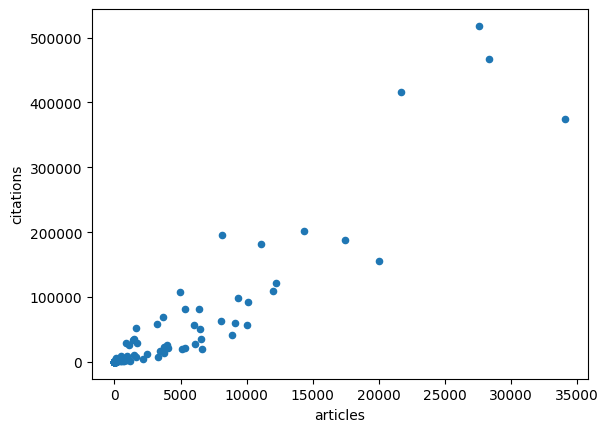

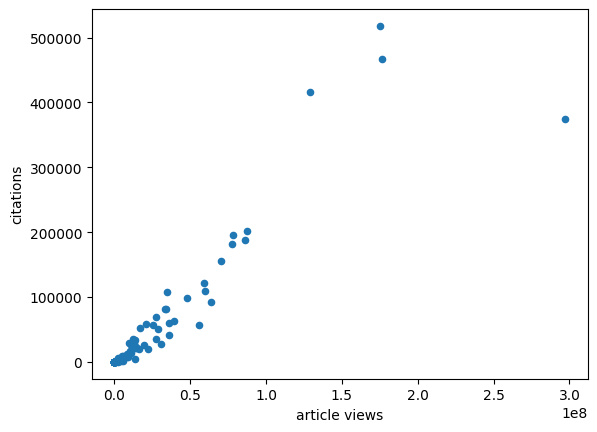

In [44]:
df_handel_nulls.plot(x="articles", y="citations", kind='scatter')
df_handel_nulls.plot(x="article views", y="citations", kind='scatter')

Eyeballing the grraphs show Frontiers in Psychology is a clear outlier in article views and less so in articles.

Its hard to make any assumptions because its only only one datapoint but this could be an indication that once a journal grows to a certain size in terms of articles and article views citations begin to drop off. Comparisons with other journals of similar size could be interesting to see if this is common. 

These graphs also illustrate how many new journals have been added the the frontiers publication roster as we have many that stack up near the lower ends of the graph.

In [45]:
df_handel_nulls["articles"].idxmax()

'Frontiers in Psychology'

In [46]:
df_handel_nulls["article views"].idxmax()

'Frontiers in Psychology'

We can visualise the rest of the correllations in a pairplot using seaborn to get a better idea of the relationshsips.

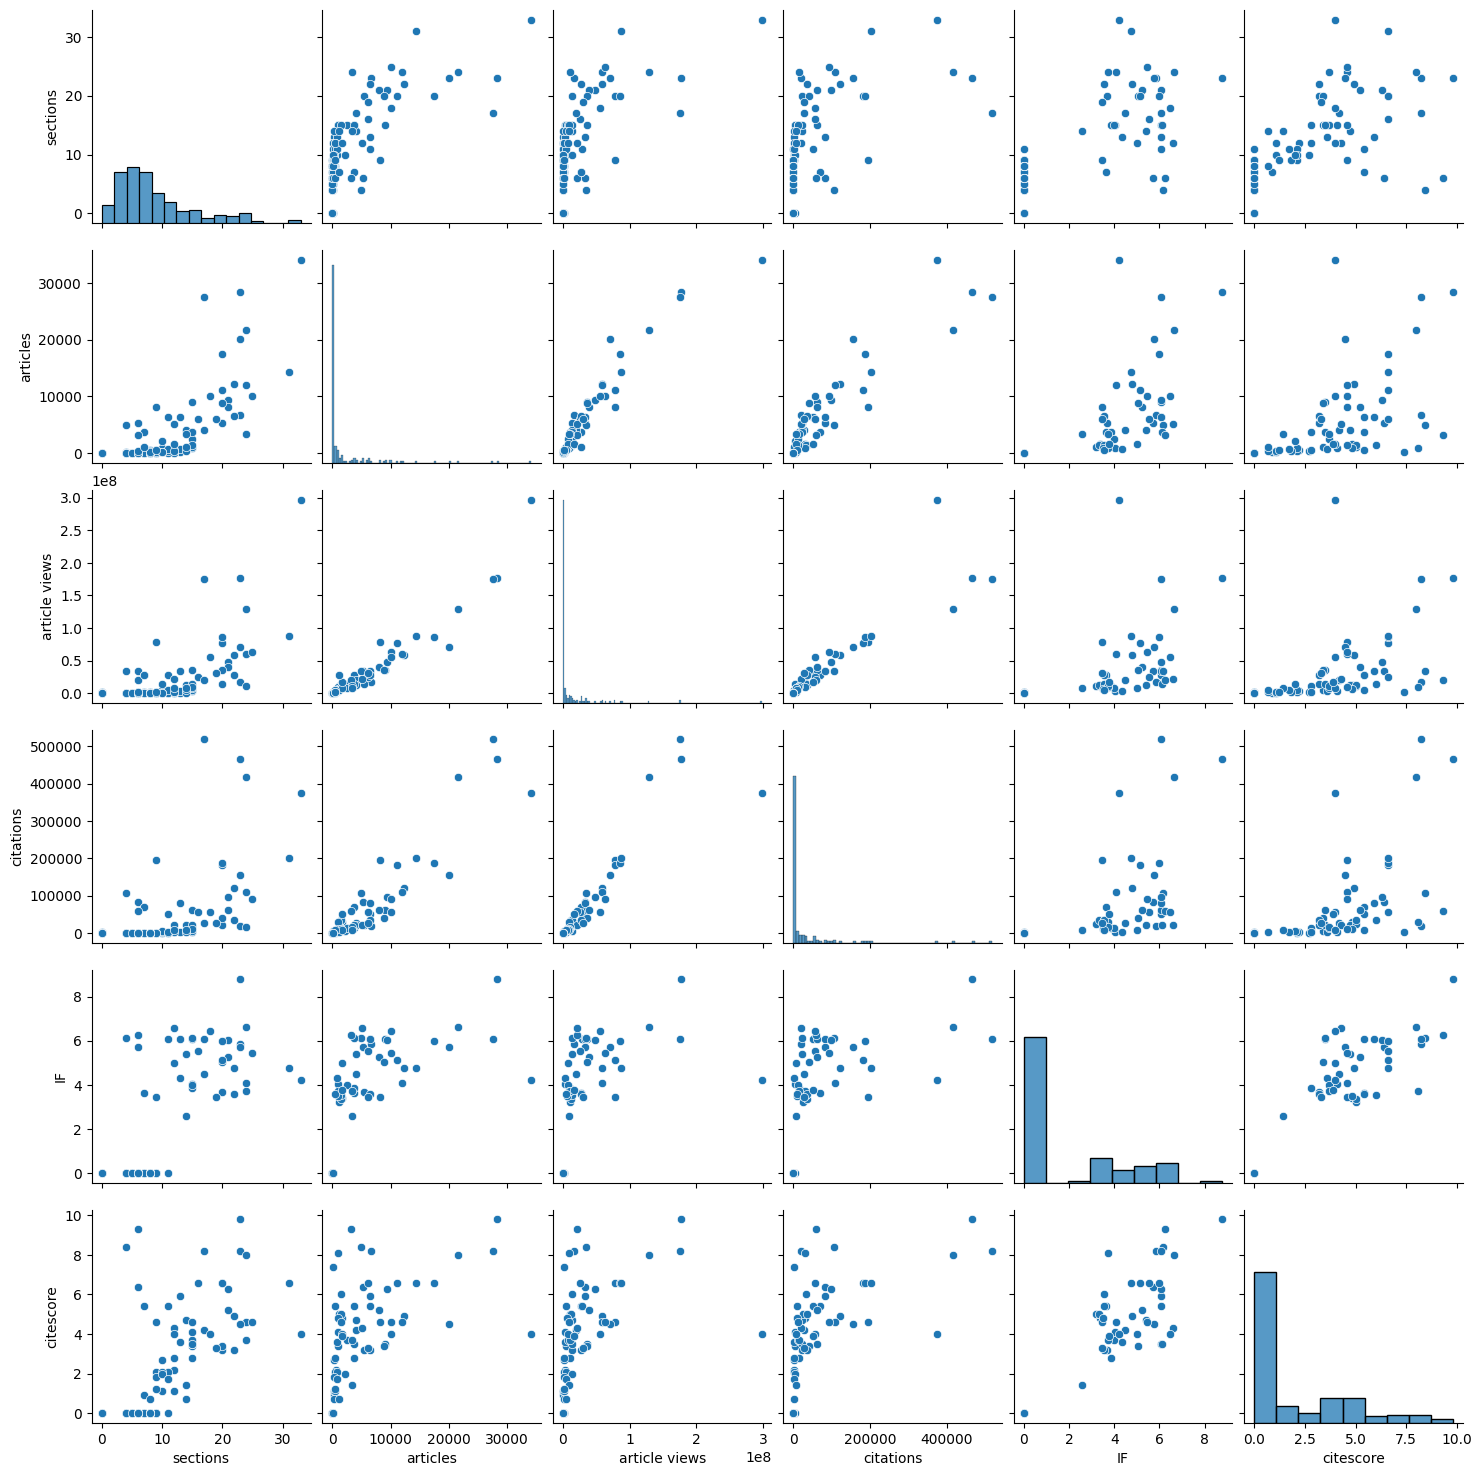

In [51]:
sns.pairplot(df_handel_nulls)

In [62]:
df_no_null_citations = df_handel_nulls.loc[df_handel_nulls["citations"].notnull()]

from sklearn.linear_model import LinearRegression
model = LinearRegression()

X = df_no_null_citations["articles"]
y = df_no_null_citations["citations"]

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, train_size=0.3)

model.fit(X_train, y_train)

from sklearn.metrics import mean_squared_error, r2_score
predictions = model.predict(X_test)
r2 = r2_score(y_test, predictions)
rmse = mean_squared_error(y_test, predictions, squared=False)

print('The r2 is: ', r2)
print('The rmse is: ', rmse)


ValueError: Expected 2D array, got 1D array instead:
array=[4.9460e+03 4.0110e+03 1.4180e+03 1.6000e+01 5.6000e+01 8.9000e+01
 1.0095e+04 1.0650e+03 1.1075e+04 1.2235e+04 9.7100e+02 2.7559e+04
 7.0000e+00 4.0540e+03 0.0000e+00 6.4310e+03 5.0000e+01 2.7000e+01
 4.7200e+02 4.7000e+01 1.6550e+03 1.1000e+01 9.0100e+02 2.1280e+03
 1.0028e+04 3.4117e+04 0.0000e+00 2.0000e+00 0.0000e+00 3.7460e+03
 0.0000e+00 1.7425e+04 3.7520e+03 1.0000e+00 6.6000e+01 9.6000e+01
 6.5270e+03 9.0880e+03 7.0000e+00 0.0000e+00 0.0000e+00 4.5000e+01
 3.6710e+03 2.8000e+01].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

<AxesSubplot:title={'center':'article views'}>

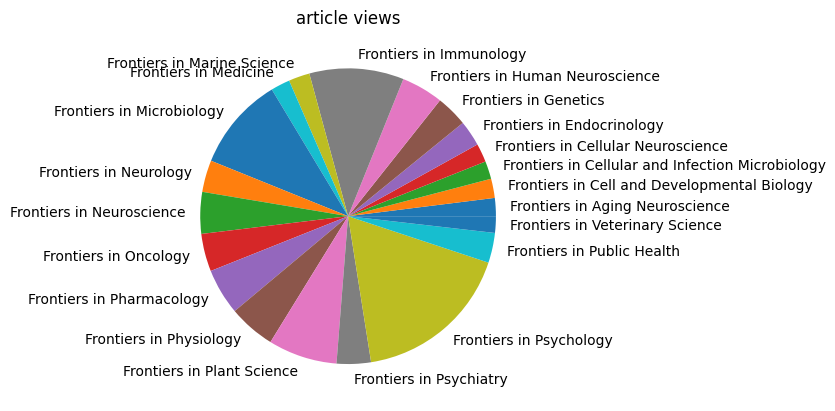

In [47]:
df_describe.loc[df_describe["article views"] > 30000000].plot.pie(y='article views', legend=False, title="article views", ylabel="")

<AxesSubplot:title={'center':'articles'}>

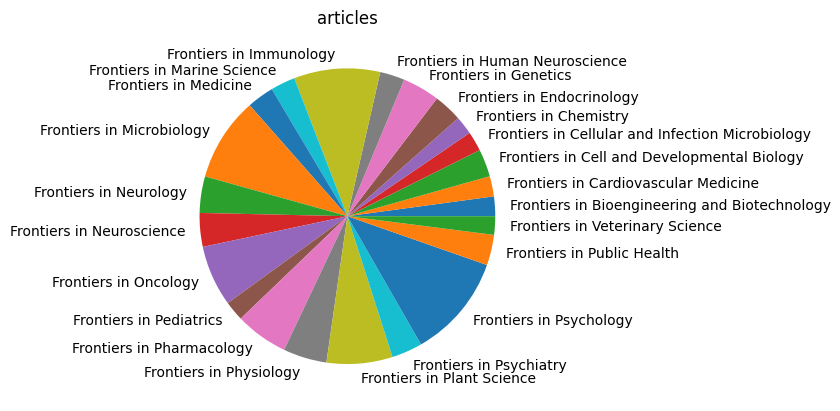

In [48]:
df_describe.loc[df_describe["articles"] > 5500].plot.pie(y='articles', legend=False, title="articles", ylabel="")